In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The GE dataset

In [2]:
buy_average = pd.read_csv("data/rsbuddy/buy_average.csv")
buy_average = buy_average.set_index('timestamp')

In [3]:
buy_average.head()

,Cannonball,Cannon_base,Cannon_stand,Cannon_barrels,Cannon_furnace,Insect_repellent,Bucket_of_wax,Candle,Bronze_arrowtips,Iron_arrowtips,...,Watchtower_teleport,Teleport_to_house,Bones_to_bananas,Bones_to_peaches,Enchant_sapphire_or_opal,Enchant_emerald_or_jade,Enchant_ruby_or_topaz,Enchant_diamond,Enchant_dragonstone,Enchant_onyx
timestamp,,,,,,,,,,,,,,,,,,,,,
1577227800,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577228101,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577228400,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577228700,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0
1577229001,174,188000,186627,0,193811,202,4800,398,0,3,...,380,461,0,831,0,0,0,0,0,0


In [4]:
buy_average.shape

(3398, 3657)

In [5]:
buy_average = buy_average.drop_duplicates()

In [6]:
buy_average.shape

(1086, 3657)

In [7]:
item_to_predict = 'Rune_scimitar'
items_selected = ['Rune_axe', 'Rune_2h_sword', 'Rune_scimitar', 'Rune_chainbody', 'Rune_full_helm', 'Rune_kiteshield']
df = buy_average[items_selected].replace(to_replace=0, method='ffill')
print(df.shape)
df.head()

(1086, 6)


,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield
timestamp,,,,,,
1577227800,7196,37882,15022,29748,20602,32079
1577229600,7123,37881,15036,29657,20600,32095
1577231400,7237,37821,15019,29577,20633,32340
1577233501,7250,37816,15018,29530,20634,32152
1577235300,7316,37819,15009,29743,20785,32119


# Feature Engineering

## Known finance features (MACD, RSI)

In [8]:
def moving_average_convergence(group, nslow=26, nfast=12):
    emaslow = group.ewm(span=nslow, min_periods=1).mean()
    emafast = group.ewm(span=nfast, min_periods=1).mean()
    result = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    return result

def moving_average(group, n=9):
    sma = group.rolling(n).mean()
    sma=sma.rename('SMA')
    return sma

def RSI(group, n=14):
    delta = group.diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(n).mean()
    RolDown = dDown.rolling(n).mean().abs()
    
    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    rsi=rsi.rename('RSI')
    return rsi

In [9]:
macd = moving_average_convergence(df[item_to_predict])
sma = moving_average(df[item_to_predict])
rsi = RSI(df[item_to_predict], 10)
finance_features = pd.concat([macd, sma, rsi], axis=1)
finance_features.head()

,MACD,emaSlw,emaFst,SMA,RSI
timestamp,,,,,
1577227800,0.000000,15022.000000,15022.000000,NaN,NaN
1577229600,0.314103,15029.269231,15029.583333,NaN,NaN
1577231400,-0.126940,15025.579596,15025.452656,NaN,NaN
1577233501,-0.360528,15023.460672,15023.100144,NaN,NaN
1577235300,-0.837998,15020.107183,15019.269185,NaN,NaN


## Fetched API features (buy quantity, sell price average)

In [10]:
sell_average = pd.read_csv("data/rsbuddy/sell_average.csv")
sell_average = sell_average.set_index('timestamp')
sell_average = sell_average.drop_duplicates()
sell_average = sell_average[items_selected].replace(to_replace=0, method='ffill')
print(sell_average.shape)
sell_average.columns = [str(col) + '_sa' for col in sell_average.columns]
sell_average.head()

(1086, 6)


,Rune_axe_sa,Rune_2h_sword_sa,Rune_scimitar_sa,Rune_chainbody_sa,Rune_full_helm_sa,Rune_kiteshield_sa
timestamp,,,,,,
1577227800,7178,37818,14979,29506,20590,32059
1577229600,7147,37848,14982,29507,20595,32052
1577231400,7150,37828,14988,29498,20597,32053
1577233501,7160,37795,14991,29448,20600,32058
1577235300,7191,37808,14995,29430,20596,32061


In [11]:
buy_quantity = pd.read_csv("data/rsbuddy/buy_quantity.csv")
buy_quantity = buy_quantity.set_index('timestamp')
buy_quantity = buy_quantity.drop_duplicates()
buy_quantity = buy_quantity[items_selected].replace(to_replace=0, method='ffill')
print(buy_quantity.shape)
buy_quantity.columns = [str(col) + '_bq' for col in buy_quantity.columns]
buy_quantity.head()

(1086, 6)


,Rune_axe_bq,Rune_2h_sword_bq,Rune_scimitar_bq,Rune_chainbody_bq,Rune_full_helm_bq,Rune_kiteshield_bq
timestamp,,,,,,
1577227800,85,234,62,1,256,220
1577229600,26,170,40,22,202,159
1577231400,4,76,55,53,75,23
1577233501,2,201,57,33,32,86
1577235300,5,241,13,29,3,91


In [12]:
sell_quantity = pd.read_csv("data/rsbuddy/sell_quantity.csv")
sell_quantity = sell_quantity.set_index('timestamp')
sell_quantity = sell_quantity.drop_duplicates()
sell_quantity = sell_quantity[items_selected].replace(to_replace=0, method='ffill')
print(sell_quantity.shape)
sell_quantity.columns = [str(col) + '_sq' for col in sell_quantity.columns]
sell_quantity.head()

(1086, 6)


,Rune_axe_sq,Rune_2h_sword_sq,Rune_scimitar_sq,Rune_chainbody_sq,Rune_full_helm_sq,Rune_kiteshield_sq
timestamp,,,,,,
1577227800,38,33,56,56,145,167
1577229600,23,23,68,59,171,112
1577231400,47,26,136,57,165,70
1577233501,47,23,151,61,89,78
1577235300,15,17,47,37,138,122


## Datetime properties

In [13]:
df['datetime'] = df.index
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour
df.head()

,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield,datetime,dayofweek,hour
timestamp,,,,,,,,,
1577227800,7196,37882,15022,29748,20602,32079,2019-12-24 22:50:00,1,22
1577229600,7123,37881,15036,29657,20600,32095,2019-12-24 23:20:00,1,23
1577231400,7237,37821,15019,29577,20633,32340,2019-12-24 23:50:00,1,23
1577233501,7250,37816,15018,29530,20634,32152,2019-12-25 00:25:01,2,0
1577235300,7316,37819,15009,29743,20785,32119,2019-12-25 00:55:00,2,0


## Differentiated signal

In [14]:
tmp = df.copy()
tmp.index = pd.to_datetime(tmp.index)

slope = pd.Series(np.gradient(tmp[item_to_predict]), df.index, name='slope')

tmp = pd.concat([tmp, slope], axis=1)
tmp.head()

,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield,datetime,dayofweek,hour,slope
timestamp,,,,,,,,,,
1970-01-01 00:00:01.577227800,7196,37882,15022,29748,20602,32079,2019-12-24 22:50:00,1,22,14.0
1970-01-01 00:00:01.577229600,7123,37881,15036,29657,20600,32095,2019-12-24 23:20:00,1,23,-1.5
1970-01-01 00:00:01.577231400,7237,37821,15019,29577,20633,32340,2019-12-24 23:50:00,1,23,-9.0
1970-01-01 00:00:01.577233501,7250,37816,15018,29530,20634,32152,2019-12-25 00:25:01,2,0,-5.0
1970-01-01 00:00:01.577235300,7316,37819,15009,29743,20785,32119,2019-12-25 00:55:00,2,0,-5.0


## Appending features to main dataframe

In [15]:
df = pd.concat([df,finance_features, sell_average, buy_quantity, sell_quantity, slope], axis=1)
df = df.dropna()
print(df.shape)
df.head()

(1076, 33)


,Rune_axe,Rune_2h_sword,Rune_scimitar,Rune_chainbody,Rune_full_helm,Rune_kiteshield,datetime,dayofweek,hour,MACD,...,Rune_chainbody_bq,Rune_full_helm_bq,Rune_kiteshield_bq,Rune_axe_sq,Rune_2h_sword_sq,Rune_scimitar_sq,Rune_chainbody_sq,Rune_full_helm_sq,Rune_kiteshield_sq,slope
timestamp,,,,,,,,,,,,,,,,,,,,,
1577246100,7165,37849,14984,29747,20687,32350,2019-12-25 03:55:00,2,3,-3.324748,...,1,2,1,71,16,40,20,113,122,38.0
1577247901,7169,37830,15050,29747,20687,32046,2019-12-25 04:25:01,2,4,-0.471082,...,1,2,112,68,15,37,13,136,123,32.0
1577249700,7163,37875,15048,29747,20798,32047,2019-12-25 04:55:00,2,4,1.538547,...,1,11,202,52,18,42,12,136,68,-47.0
1577251500,7194,37915,14956,29747,20798,32090,2019-12-25 05:25:00,2,5,-2.309169,...,1,11,155,52,315,29,14,122,96,-32.5
1577253301,7186,37907,14983,29420,20573,32131,2019-12-25 05:55:01,2,5,-3.579239,...,1,355,86,519,308,19,548,1702,120,27.0


# Time Series Analysis

In [16]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [17]:
TRAIN_SPLIT = 750

In [18]:
tf.random.set_seed(13)

## Part 1: Univariate time series

In [19]:
uni_data = df[item_to_predict]
uni_data.head()

timestamp
1577246100    14984
1577247901    15050
1577249700    15048
1577251500    14956
1577253301    14983
Name: Rune_scimitar, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000157828847F0>],
      dtype=object)

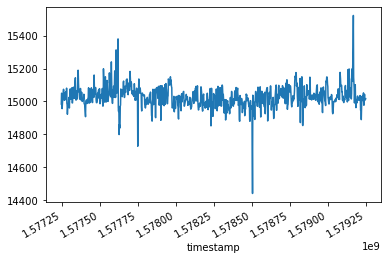

In [20]:
uni_data.plot(subplots=True)

In [21]:
uni_data = uni_data.values

In [22]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [23]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [24]:
univariate_past_history = 30
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [25]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[-0.56791607]
 [ 0.44933906]
 [ 0.41851315]
 [-0.99947886]
 [-0.58332903]
 [-0.1671792 ]
 [ 0.15649289]
 [ 0.68053341]
 [ 0.81925002]
 [ 0.69594637]
 [-0.13635329]
 [-0.21341807]
 [ 0.44933906]
 [ 0.44933906]
 [ 0.43392611]
 [ 0.43392611]
 [ 0.58805567]
 [ 0.01777628]
 [-0.19800512]
 [ 0.92714072]
 [-0.49085129]
 [-0.6295679 ]
 [-1.52351938]
 [-1.10736956]
 [-0.59874199]
 [-0.6295679 ]
 [-0.2750699 ]
 [ 0.04860219]
 [-0.19800512]
 [-0.93782703]]

 Target to predict
0.01777627662747813


In [26]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [27]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

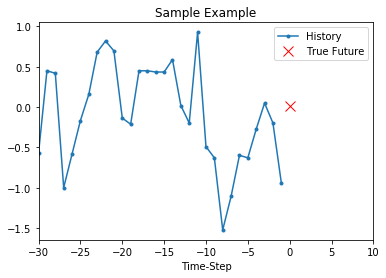

In [28]:
plot = show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plot.show()

### Baseline


In [29]:
def baseline(history):
  return np.mean(history)

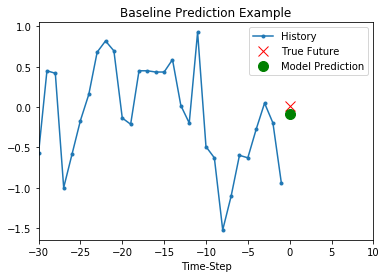

In [30]:
plot = show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')
plot.show()

### Recurrent neural network

In [31]:
BATCH_SIZE = 32
BUFFER_SIZE = 30

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [32]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [33]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(32, 1)


In [34]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 33ms/step - loss: 0.6622 - val_loss: 0.6215
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.6231 - val_loss: 0.5782
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5783 - val_loss: 0.5414
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5350 - val_loss: 0.5074
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.5101 - val_loss: 0.4969
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.4975 - val_loss: 0.4965
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.4989 - val_loss: 0.4966
Epoch 8/10
200/200 [==============================] - 3s 15ms/step - loss: 0.4950 - val_loss: 0.4969
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.4990 - val_loss: 0.4987
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model


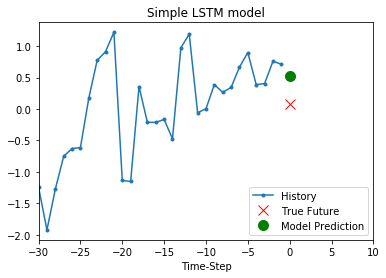

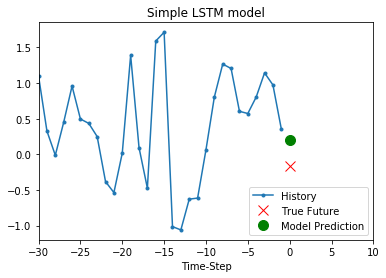

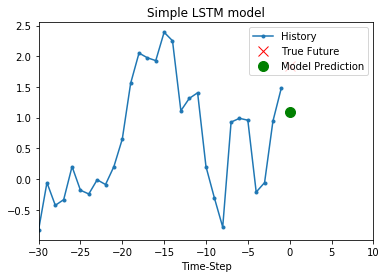

In [35]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Part 2: Multivariate time series

In [36]:
features_considered = ['slope', item_to_predict]
# ['MACD', 'RSI', 'SMA', 'Rune_axe', 'Rune_axe_bq', 'Rune_axe_sq', 'Rune_axe_sa', 'hour', 'dayofweek', 'slope'
# 'Rune_2h_sword', 'Rune_scimitar', 'Rune_chainbody', 'Rune_full_helm', 'Rune_kiteshield']

In [37]:
features = df[features_considered]
# features.index = df['timestamp']
features.head()

,slope,Rune_scimitar
timestamp,,
1577246100,38.0,14984
1577247901,32.0,15050
1577249700,-47.0,15048
1577251500,-32.5,14956
1577253301,27.0,14983


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000157934827B8>,
      dtype=object)

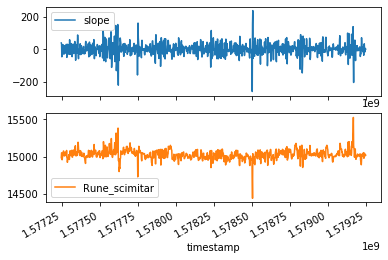

In [38]:
features.plot(subplots=True)

In [39]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [40]:
dataset = (dataset-data_mean)/data_std

### Single step model

In [41]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [42]:
past_history = 30
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [43]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 2)


In [44]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [45]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.add(tf.keras.layers.Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.add(tf.keras.layers.Dropout(0.2))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae') #learning_rate=0.001

In [46]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(32, 1)


In [47]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 7s 37ms/step - loss: 0.6936 - val_loss: 0.6261
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6629 - val_loss: 0.6050
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6430 - val_loss: 0.5973
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6269 - val_loss: 0.5810
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6241 - val_loss: 0.5642
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.5973 - val_loss: 0.5452
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5905 - val_loss: 0.5440
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5798 - val_loss: 0.5262
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.5704 - val_loss: 0.5306
Epoch 10/10
200/200 [===========================

In [48]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

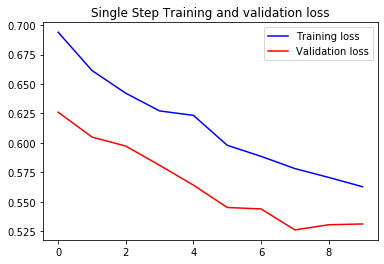

In [49]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future

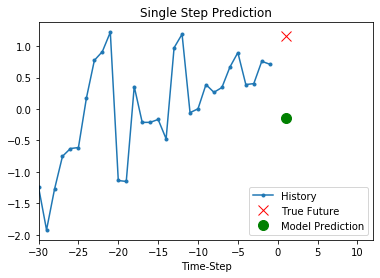

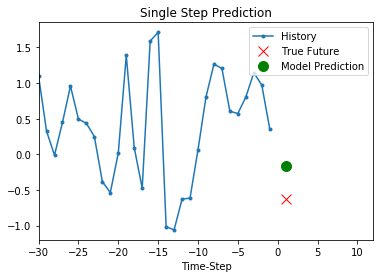

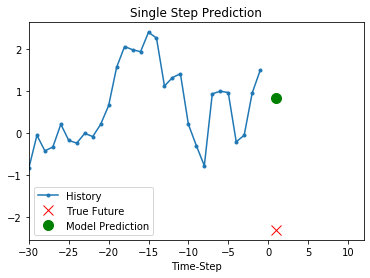

In [50]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [51]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [52]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (30, 2)

 Target temperature to predict : (5,)


In [53]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [54]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

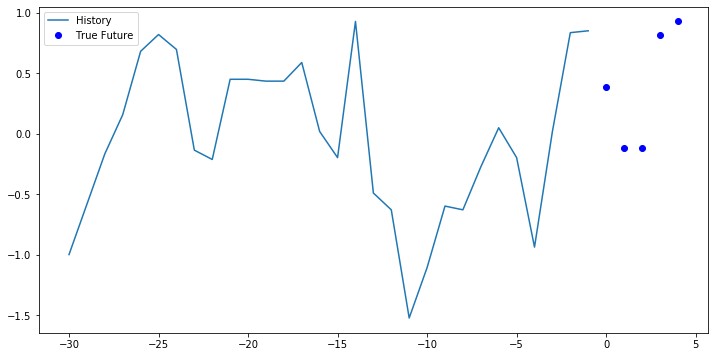

In [55]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [56]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))
multi_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.Dense(future_target))
multi_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.Dense(future_target))
multi_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.Dense(future_target))
multi_step_model.add(tf.keras.layers.Dropout(0.5))
multi_step_model.add(tf.keras.layers.Dense(future_target))



multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [57]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(32, 5)


In [58]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 14s 72ms/step - loss: 0.7213 - val_loss: 0.6565
Epoch 2/10
200/200 [==============================] - 8s 39ms/step - loss: 0.7146 - val_loss: 0.6336
Epoch 3/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6974 - val_loss: 0.6361
Epoch 4/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6921 - val_loss: 0.6210
Epoch 5/10
200/200 [==============================] - 6s 29ms/step - loss: 0.6820 - val_loss: 0.6054
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6688 - val_loss: 0.5976
Epoch 7/10
200/200 [==============================] - 6s 32ms/step - loss: 0.6712 - val_loss: 0.6127
Epoch 8/10
200/200 [==============================] - 6s 28ms/step - loss: 0.6623 - val_loss: 0.5830
Epoch 9/10
200/200 [==============================] - 6s 28ms/step - loss: 0.6614 - val_loss: 0.5789
Epoch 10/10
200/200 [==========================

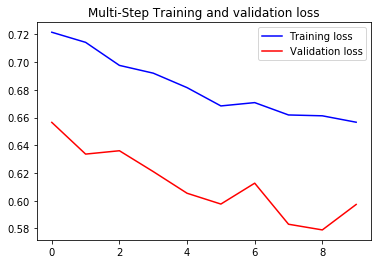

In [59]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future

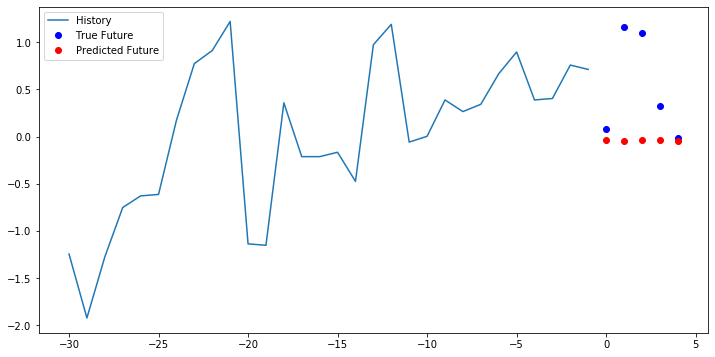

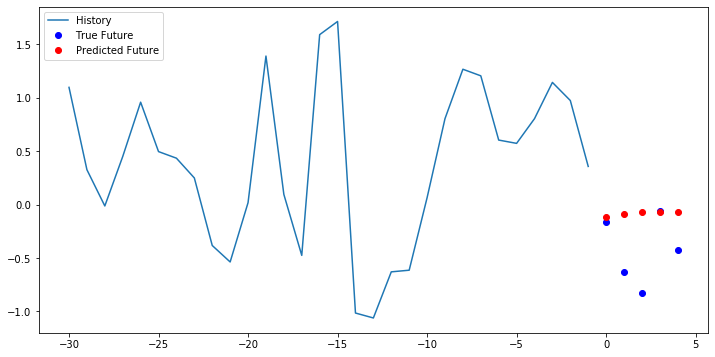

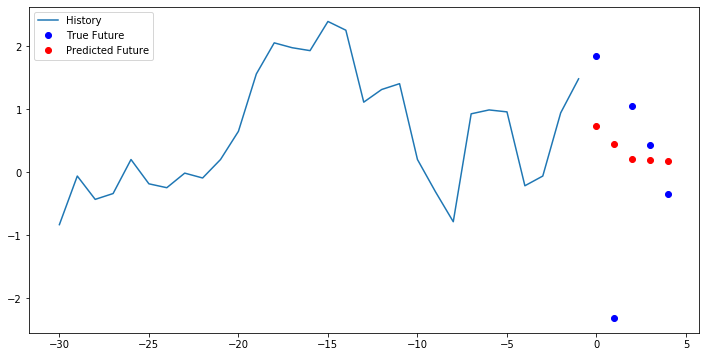

In [60]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Feature Selection

In [61]:
# Univariate linear regression tests and Recursive Feature Elimination (RFE)
from sklearn import datasets
from sklearn.feature_selection import RFE, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Regression F Test

In [62]:
features = df.drop(['datetime'], axis=1).copy()

# normalize dataset
dataset=(features-features.mean())/features.std()
    
X = dataset.drop([item_to_predict], axis=1)
y = dataset[item_to_predict]
print(X.shape)
print(y.shape)

# define feature selection
fs = SelectKBest(score_func=f_regression, k=7)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

# Get scores for each of the columns
scores = fs.scores_
for idx, col in enumerate(X.columns): 
    print("feature: {: >20} \t score: {: >10}".format(col, round(scores[idx],5)))

# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
features_df_new = X.iloc[:,cols]
print(features_df_new.columns)
features_df_new.head()


(1076, 31)
(1076,)
(1076, 7)
feature:             Rune_axe 	 score:    0.19375
feature:        Rune_2h_sword 	 score:    3.87857
feature:       Rune_chainbody 	 score:     3.5647
feature:       Rune_full_helm 	 score:    22.9884
feature:      Rune_kiteshield 	 score:    2.19837
feature:            dayofweek 	 score:    1.55558
feature:                 hour 	 score:   10.97583
feature:                 MACD 	 score:  827.07558
feature:               emaSlw 	 score:  394.28828
feature:               emaFst 	 score:  804.62128
feature:                  SMA 	 score:  452.37405
feature:                  RSI 	 score:    489.208
feature:          Rune_axe_sa 	 score:    2.27552
feature:     Rune_2h_sword_sa 	 score:    4.43778
feature:     Rune_scimitar_sa 	 score:   93.11519
feature:    Rune_chainbody_sa 	 score:   18.11522
feature:    Rune_full_helm_sa 	 score:   31.46169
feature:   Rune_kiteshield_sa 	 score:   11.90286
feature:          Rune_axe_bq 	 score:     9.8511
feature:     Rune_2h_

,MACD,emaSlw,emaFst,SMA,RSI,Rune_scimitar_sa,Rune_scimitar_bq
timestamp,,,,,,,
1577246100,-0.253769,-0.602069,-0.577587,-0.460418,-1.004653,0.259116,1.351232
1577247901,-0.035878,-0.431754,-0.362097,-0.376529,0.262390,0.590342,-0.574403
1577249700,0.117567,-0.297200,-0.198521,-0.295347,0.598359,0.590342,-0.659986
1577251500,-0.176225,-0.531057,-0.492483,-0.438770,-0.874509,0.557220,-0.189276
1577253301,-0.273201,-0.632707,-0.609303,-0.506422,-0.349149,0.292239,1.137272


### Recursive Feature Elimination (RFE)

In [63]:
X = dataset.drop([item_to_predict], axis=1)
y = dataset[item_to_predict]

# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 7)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataset.drop([item_to_predict], axis=1).columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

Selected Features:
MACD
emaSlw
emaFst
SMA
RSI
Rune_scimitar_bq
slope


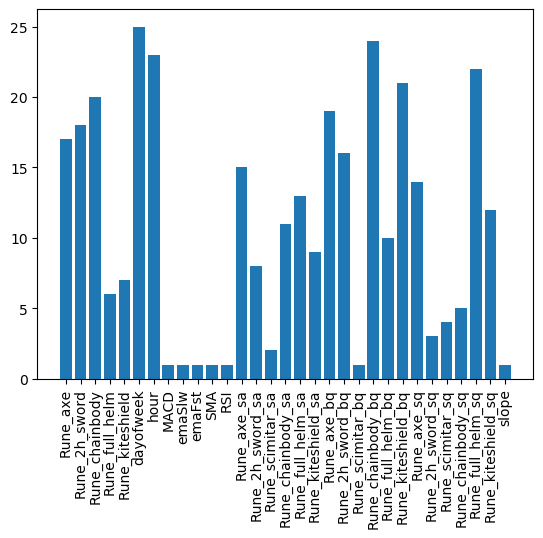

In [64]:
mpl.rcParams.update(mpl.rcParamsDefault)
# plot feature rank
names = dataset.drop([item_to_predict], axis=1).columns.values
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.xticks(rotation=90);
plt.show()

### Going through individual features

In [65]:
all_features = dataset.drop([item_to_predict], axis=1).columns.values

for feature in all_features:
    print("processing feature: {}".format(feature))
    features_considered = [feature, item_to_predict] 

    features = df[features_considered]
    # features.index = df['timestamp']
    features.head()

    dataset = features.values
    data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
    data_std = dataset[:TRAIN_SPLIT].std(axis=0)

    dataset = (dataset-data_mean)/data_std

    past_history = 30
    future_target = 1
    STEP = 1

    x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                       TRAIN_SPLIT, past_history,
                                                       future_target, STEP,
                                                       single_step=True)
    x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                                   TRAIN_SPLIT, None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

    train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
    train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
    val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

    single_step_model = tf.keras.models.Sequential()
    single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
    single_step_model.add(tf.keras.layers.Dense(1))
    single_step_model.add(tf.keras.layers.Dropout(0.2))
    single_step_model.add(tf.keras.layers.Dense(1))
    single_step_model.add(tf.keras.layers.Dropout(0.2))
    single_step_model.add(tf.keras.layers.Dense(1))

    single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

    single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_single,
                                                validation_steps=50,
                                                verbose=0)

    print("validation loss hist: {}\n".format(single_step_history.history['val_loss']))

processing feature: Rune_axe
validation loss hist: [0.6372475504875184, 0.6354854226112365, 0.6398900598287582, 0.6420884177088737, 0.6423998087644577, 0.6710284754633904, 0.6754960522055626, 0.6859448239207268, 0.7325440645217896, 0.7138199970126152]

processing feature: Rune_2h_sword
validation loss hist: [0.6384613409638404, 0.6437366291880607, 0.6452618971467018, 0.6497030898928642, 0.648300652205944, 0.6596855208277702, 0.6755128979682923, 0.6766391336917877, 0.7118756413459778, 0.7047049894928932]

processing feature: Rune_chainbody
validation loss hist: [0.6384763643145561, 0.643291525542736, 0.6646424889564514, 0.6617202699184418, 0.6612809434533119, 0.6980746746063232, 0.713511174917221, 0.7292855709791184, 0.7417385593056679, 0.7438014015555382]

processing feature: Rune_full_helm
validation loss hist: [0.6421618774533272, 0.6445500552654266, 0.6426517367362976, 0.6475637033581734, 0.660388033092022, 0.6592296659946442, 0.6696386411786079, 0.678221108019352, 0.690079689025878